In [54]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Importation mnist

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
X_train_full.shape

(60000, 28, 28)

# Normalization

In [7]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

# Visualization

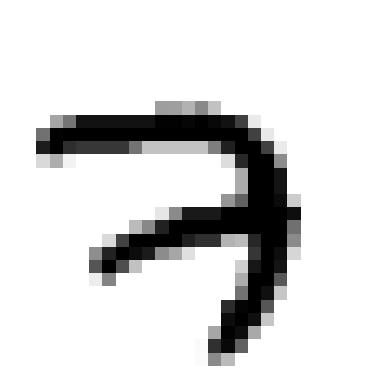

In [11]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

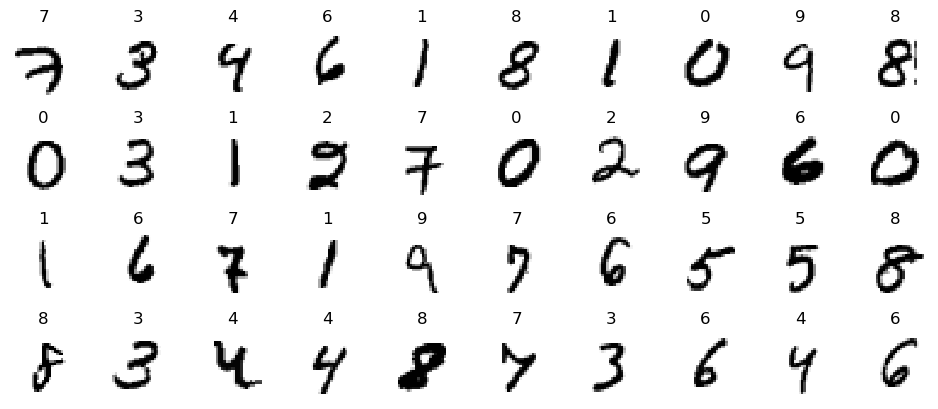

In [13]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Model and optimal learning rate

In [19]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [25]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

C:\Users\nicolas.sales\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
expon_lr = ExponentialLearningRate(factor=1.005)

In [33]:
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5333 - loss: 1.5534 - val_accuracy: 0.1126 - val_loss: 2.3911


Text(0, 0.5, 'Loss')

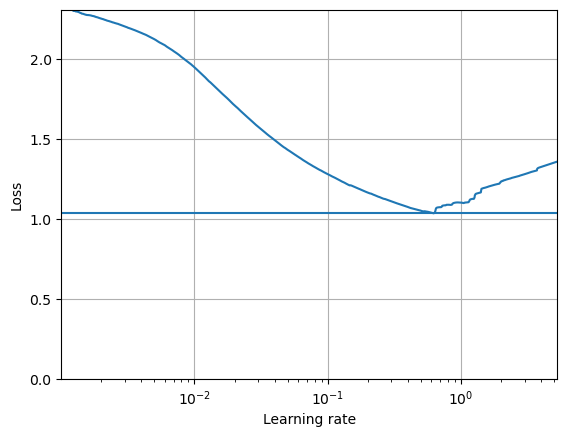

In [44]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1

In [46]:
tf.keras.backend.clear_session() # Cette fonction garantit que l'environnement est "propre" avant de définir un nouveau modèle, ce qui évite des conflits ou des problèmes de mémoire.
np.random.seed(42)
tf.random.set_seed(42)

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [56]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

WindowsPath('my_mnist_logs/run_001')

In [58]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8693 - loss: 0.4113 - val_accuracy: 0.9672 - val_loss: 0.1058
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9700 - loss: 0.1008 - val_accuracy: 0.9700 - val_loss: 0.0908
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9809 - loss: 0.0635 - val_accuracy: 0.9760 - val_loss: 0.0839
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9863 - loss: 0.0445 - val_accuracy: 0.9738 - val_loss: 0.0949
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9902 - loss: 0.0326 - val_accuracy: 0.9768 - val_loss: 0.0888
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9913 - loss: 0.0266 - val_accuracy: 0.9772 - val_loss: 0.0902
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9924 - loss: 0.0220 - val_accuracy: 0.9748 - val_loss: 0.1097
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9934 - loss:

In [60]:
model = tf.keras.models.load_model("my_mnist_model.keras") # best model
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9736 - loss: 0.0957


[0.07876911759376526, 0.9778000116348267]

In [64]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs